In [1]:
from alpaca_farm.models import reward_model
from alpaca_farm.inference.decode import load_model_and_tokenizer_for_inference 
from alpaca_farm.inference.score import score_sequences_with_huggingface_given_model
from transformers import T5Tokenizer, T5ForConditionalGeneration
from alpaca_farm import utils
import pandas as pd
from statistics import mean, stdev
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from src.utils.samp_utils import gen_row, get_reward_single, get_reward_double
import alpaca_farm.data_preprocessor as data_preprocessor
import random
import math
device="cuda:1"

/home/prasann/miniconda3/envs/aplora/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/prasann/miniconda3/envs/aplora/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda120.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 120
CUDA SETUP: Loading binary /home/prasann/miniconda3/envs/aplora/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda120.so...


/home/prasann/miniconda3/envs/aplora/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /home/prasann/miniconda3/envs/aplora did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/home/prasann/miniconda3/envs/aplora/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
steamtok = T5Tokenizer.from_pretrained('stanfordnlp/SteamSHP-flan-t5-xl')
steamshp = T5ForConditionalGeneration.from_pretrained('stanfordnlp/SteamSHP-flan-t5-xl').to(device)
steamshp.eval()

In [2]:
model, tokenizer = load_model_and_tokenizer_for_inference(
    model_name_or_path="/home/prasann/Projects/tfr-decoding/apfarm_models/reward-model-human/",
    model_cls=reward_model.RewardModel,
    cache_dir=None,
    model_kwargs=dict(
        torch_dtype=utils.convert_str_dtype_to_torch_dtype(None),
        flash_attn=False,
    ),
)

Loading model for inference: /home/prasann/Projects/tfr-decoding/apfarm_models/reward-model-human/
Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.37s/it]


In [ ]:
model, tokenizer = load_model_and_tokenizer_for_inference(
    model_name_or_path='/home/prasann/Projects/tfr-decoding/apfarm_models/ppo-human/',
    cache_dir=None,
    model_kwargs=dict(torch_dtype=utils.convert_str_dtype_to_torch_dtype(None)),
)

In [3]:
def generate_stuff(question):
    pdict_path = "/home/prasann/Projects/tfr-decoding/alpaca_farm/examples/prompts/v0_inputs_noinputs.json"
    prompts, list_dict_data, metadata = data_preprocessor.format_prompt_with_data_frame(
        df=pd.DataFrame({'instruction':[question], 'input':[""]}),
        prompt_dict=utils.jload(pdict_path),
    )
    inps = tokenizer(prompts, return_tensors="pt").to("cuda")
    outs = model.generate(inps.input_ids, attention_mask=inps.attention_mask, do_sample=True, temperature=1.0,max_new_tokens=300,num_return_sequences=2,)
    return tokenizer.batch_decode(outs, skip_special_tokens=True)

In [ ]:
otmp = generate_stuff(alldfs['instruction'].loc[0])

In [ ]:
scos = [float(get_reward_single({"context": alldfs['instruction'].loc[0], "hyp":o}, steamtok, steamshp)) for o in otmp]
print(scos)

In [ ]:
print(otmp[1])

In [9]:
ppoouts = pd.read_json("alpaca_farm/bon_outs/ppohum.jsonl", orient="records").drop(columns=['input', 'scorer_name_or_path'])
sftouts = pd.read_json("alpaca_farm/bon_outs/sft.jsonl", orient="records").drop(columns=['input', 'scorer_name_or_path'])


In [4]:
def scoreseq(inp, ans):
    # TODO make a batched version if necessary
    template = "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:{response}"
    seq = template.format(instruction=inp, response=ans)
    return score_sequences_with_huggingface_given_model(model, tokenizer, [seq], per_device_batch_size=1)
    

In [ ]:
inp = ppoouts.loc[1]['instruction']
hyp = ppoouts.loc[1]['output'][1]
scoreseq(inp, hyp)

In [ ]:
ppoouts.loc[1].top_index[0]

In [4]:
def printex(row):
    print(row.instruction)
    for i in [1, 2, 6, 7]:
        topind = row.top_index[i]
        print(row.top_scores[topind])
        print(row.output[topind])

In [ ]:

ind = 15
print("_________")
print("BEFORE PPO")
printex(sftouts.loc[ind])
print("_________")
print("AFTER PPO")
printex(ppoouts.loc[ind])


In [ ]:
mean([mean(m) for m in ppoouts.top_scores])

In [ ]:
lendist = []
for sc in sftouts.output:
    lendist.extend([len(tokenizer(s).input_ids) for s in sc])
print(mean(lendist))
plt.hist(lendist)

In [ ]:
scodist = []
for sc in sftouts.top_scores:
    scodist.extend(sc)
plt.hist(scodist)

In [ ]:
nldist = []
nsdist = []
for i in range(len(lendist)):
    if lendist[i]>=300:
        continue
    nldist.append(lendist[i])
    nsdist.append(scodist[i])

In [ ]:
spearmanr(nldist, nsdist)

In [ ]:
plt.scatter(nldist, nsdist)

In [ ]:
sftouts.loc[7]['output']

In [8]:
from os import listdir

In [3]:
dfs = []
for dir in listdir("alpaca_farm/bon_outs/"):
    if 'eli' in dir:
        dfs.append(pd.read_json("alpaca_farm/bon_outs/"+dir, orient='records'))

In [5]:
ppo_diag = pd.read_json("alpaca_farm/bon_outs/ppohum_diag.jsonl", orient='records').drop(columns=["scorer_name_or_path", 'input'])
sft_diag = pd.read_json("alpaca_farm/bon_outs/sft_diag.jsonl", orient='records')

In [33]:
out = qpref.predsingle(sft_diag.instruction[1], sft_diag.output[1][0], True)
torch.topk(out[1][0], 5)

torch.return_types.topk(
values=tensor([[-2.6328, -2.8228, -5.6379, -6.0552, -8.4292]], device='cuda:0'),
indices=tensor([[2163, 4273,  465,  150,    3]], device='cuda:0'))

In [30]:
cprobs = []
for c in [2163, 4273, 465, 150]:
    out.sequences[0][1] = c
    transition_scores = qpref.model.compute_transition_scores(
        out.sequences, out.scores, normalize_logits=True
    )
    cprobs.append(float(np.exp(transition_scores[0][0].cpu())))
#allprobs.append(cprobs)

torch.return_types.topk(
values=tensor([[-2.5651, -2.7877, -3.8611, -4.2022, -6.7743]], device='cuda:0'),
indices=tensor([[2163, 4273,  465,  150,   94]], device='cuda:0'))

In [23]:
cprobs

[0.0015379308024421334,
 0.0051237186416983604,
 3.077745350310579e-05,
 2.3826558390283026e-05]

In [14]:
out = qpref.predsingle(sft_diag.instruction[0], sft_diag.output[0][0], True)

In [19]:
out.scores[0].cpu().numpy()

array([[-61.952282,  -8.138006, -13.045629, ..., -61.759758, -65.776535,
        -64.98529 ]], dtype=float32)

In [ ]:
sft_diag

In [16]:
ppo_diag.to_json("alpaca_farm/bon_outs/sft_diag.jsonl", orient='records')

In [18]:
ppo_diag

NameError: name 'ppo_diag' is not defined

In [4]:
alldfs = pd.concat(dfs).reset_index(drop=True).drop(columns=['input', 'scorer_name_or_path'])

In [5]:
alldfs

,instruction,output,top_sequence,top_index,top_scores
0,"Gorillaz and their virtual band ""history""I am ...",[Gorillaz is a British virtual band created in...,[Below is an instruction that describes a task...,"[1, 0]","[0.39429283142089805, 0.7290570735931391]"
1,If a RAR or ZIP file just make another file/gr...,"[Yes, you can keep compressing RAR and ZIP fil...",[Below is an instruction that describes a task...,"[1, 0]","[1.037175416946411, 1.441125512123108]"
2,Why do Catalonia and the rest of Spain think e...,[The conflict between Catalonia and the rest o...,[Below is an instruction that describes a task...,"[0, 1]","[1.635269045829773, 0.12795141339302002]"
3,Who chooses where the Olympics are going to be...,[The International Olympic Committee (IOC) is ...,[Below is an instruction that describes a task...,"[1, 0]","[-0.598800957202911, 2.12459659576416]"
4,How could the governments of USA / UK have giv...,[It is understandable that you may be confused...,[Below is an instruction that describes a task...,"[0, 1]","[0.7304080724716181, 0.454102754592895]"
...,...,...,...,...,...
16695,Pangaea: Why was there just a single giant lan...,[The hypothesis of a single super-continent is...,[Below is an instruction that describes a task...,"[0, 1]","[2.8094208240509033, 2.256419658660888]"
16696,"All the different FPS ""netcode"" terminology li...",[Netcode is a term used to refer to the networ...,[Below is an instruction that describes a task...,"[0, 1]","[1.205457210540771, 0.6027202010154721]"
16697,Where do last names come from?There's a few qu...,[Last names are thought to have originated in ...,[Below is an instruction that describes a task...,"[1, 0]","[1.125969529151916, 1.569443464279174]"
16698,"Why is the skin on penises so dark, compared t...",[The skin on penises is darker than other area...,[Below is an instruction that describes a task...,"[0, 1]","[1.840420961380004, 1.813018083572387]"


In [ ]:
alldfs

In [6]:
def scoind(ind, adf):
    row = adf.loc[ind]
    scos = [float(get_reward_single({"context": row['instruction'], "hyp":o}, steamtok, steamshp)) for o in row['output']]
    return scos

def budgind(ind, adf):
    row = adf.loc[ind]
    budgs = [len(preftok(o).input_ids) for o in row['output']]
    return budgs

def adaptbase(inpdf, thresh, mrange):
    inds = list(range(8))
    fscos = []
    budgets = []
    for ind in range(len(inpdf)):
        slist = inpdf.top_scores[ind]
        blist = inpdf.budgs[ind]
        random.shuffle(inds)
        tmp = []
        budget = 0
        # get adaptive score
        for i in inds[:mrange]:
            budget = budget+blist[i]
            if slist[i]>thresh:
                fscos.append(slist[i])
                break
            tmp.append(slist[i])
            if i==inds[mrange-1]:
                fscos.append(max(tmp))
        budgets.append(budget)
    return mean(fscos), mean(budgets)

def adaptive_prefsort(inpdf, thresh, mrange, pf, hstop):
    inds = list(range(8))
    fscos = []
    budgets = []
    for ind in range(len(inpdf)):
        # score list and list of budgets
        slist = inpdf.top_scores[ind]
        blist = inpdf.budgs[ind]
        # list with prefix metric scores (specifically final class)
        plist = [(a[-1]) for a in inpdf["probs"+str(pf)][ind]]
        # mix up what order we get stuff in
        random.shuffle(inds)
        tmp = []
        # get prob values
        nplist = [plist[p] for p in inds[:mrange]]
        
        # get indices to use
        sortps = [inds[pl] for pl in np.argsort(nplist)]
        sortps.reverse()
        # if ind==0:
        #     print(plist)
        #     print(slist)
        #     print(sortps)
        budget = pf*mrange
        # get adaptive score
        for i in sortps[:hstop]:
            budget = budget+blist[i]
            budget = budget-pf # already part of budget, remove
            if slist[i]>thresh:
                fscos.append(slist[i])
                break
            tmp.append(slist[i])
            if i==sortps[hstop-1]:
                fscos.append(max(tmp))
        budgets.append(budget)
    return mean(fscos), mean(budgets)

In [ ]:
mean([mean(m) for m in ])

In [74]:
for j in range(1, 9):
    scos, buds = [], []
    for i in range(500):
        s, b = adaptbase(ppo_diag, 1.9, j)
        # s, b = samprer(fulld,  j)
        scos.append(s)
        buds.append(b)
    print(j, " ", mean(scos), " ", mean(buds))

1   1.6619658419674632   200.37536
2   1.8759138082480427   332.33832
3   1.9542514915072915   436.78604
4   2.0008125191187855   519.75
5   2.034500072739124   589.67936
6   2.055715355763435   651.35396
7   2.0730803957986828   706.13488
8   2.0851175624513623   754.21032


In [75]:
for j in range(1, 9):
    scos, buds = [], []
    for i in range(500):
        s, b = adaptive_prefsort(ppo_diag, 1.9, 8, 20, j)
        # s, b = samprer(fulld,  j)
        scos.append(s)
        buds.append(b)
    print(j, " ", mean(scos), " ", mean(buds))

1   1.6459653782844539   328.4
2   1.8412334251403806   453.6448
3   1.9048488052892683   546.46916
4   1.9699764615392683   642.05956
5   2.00027773258686   701.71116
6   2.0102007935047146   765.09068
7   2.0384804749488827   830.03264
8   2.062990820407867   877.5112


In [ ]:
ascos = []
for i in range(50):
    print(i)
    ascos.append(scoind(i, sft_diag))

In [11]:
sft_diag['shpscos'] = ascos

In [73]:
ppo_diag['budgs'] = [budgind(i, ppo_diag) for i in range(len(ppo_diag))]

In [ ]:
mean([mean(m) for m in sft_diag['budgs']])

In [7]:
def make_prefs(indf, tok, pflen):
    res = []
    for h in indf.output:
        prefs = [tok.decode(tok(hyp).input_ids[:pflen], skip_special_tokens=True) for hyp in h]
        res.append(prefs)
    return res
CLASSES = [71, 272, 205, 309]
def getprobs(indf, ex):
    allprobs = []
    for num in range(8):
        out = qpref.predsingle(indf['instruction'][ex], indf['pf20'][ex][num], True)
        cprobs = []
        for c in CLASSES:
            out.sequences[0][1] = c
            transition_scores = qpref.model.compute_transition_scores(
                out.sequences, out.scores, normalize_logits=True
            )
            cprobs.append(float(np.exp(transition_scores[0][0].cpu())))
        allprobs.append(cprobs)
    return allprobs

In [ ]:
ppo_diag['probs20'][0]

In [8]:
import numpy as np
import torch
torch.cuda.empty_cache()

In [9]:
from train_prefmod_multi import T5BinaryClassifier, validate

In [52]:
pfname = 'stanfordnlp/SteamSHP-flan-t5-xl'
pfmod_path = "/home/prasann/Projects/tfr-decoding/lightning_logs/bigmulti_model/checkpoints/epoch=3-step=5311.ckpt/" #"./lightning_logs/aphuman_multi/checkpoints/epoch=4-step=20708.ckpt"

In [19]:
del qpref

In [30]:
import deepspeed
import torch

In [12]:
# get prefix model
qpref = T5BinaryClassifier()

Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.14s/it]


In [35]:
checkpoint = torch.load(pfmod_path+"pytorch_model.bin", map_location=lambda storage, loc: storage)

In [53]:
left = torch.load(pfmod_path+"checkpoint/mp_rank_00_model_states.pt")

In [60]:
left['module'].keys()

odict_keys(['_forward_module.model.shared.weight', '_forward_module.model.encoder.embed_tokens.weight', '_forward_module.model.encoder.block.0.layer.0.SelfAttention.q.weight', '_forward_module.model.encoder.block.0.layer.0.SelfAttention.k.weight', '_forward_module.model.encoder.block.0.layer.0.SelfAttention.v.weight', '_forward_module.model.encoder.block.0.layer.0.SelfAttention.o.weight', '_forward_module.model.encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', '_forward_module.model.encoder.block.0.layer.0.layer_norm.weight', '_forward_module.model.encoder.block.0.layer.1.DenseReluDense.wi_0.weight', '_forward_module.model.encoder.block.0.layer.1.DenseReluDense.wi_1.weight', '_forward_module.model.encoder.block.0.layer.1.DenseReluDense.wo.weight', '_forward_module.model.encoder.block.0.layer.1.layer_norm.weight', '_forward_module.model.encoder.block.1.layer.0.SelfAttention.q.weight', '_forward_module.model.encoder.block.1.layer.0.SelfAttention.k.weight', '_forward_

In [47]:
from collections import OrderedDict
new_state_dict = OrderedDict()

for key, value in checkpoint.items():
    if "forward" in key:
        name = key.replace("_forward_module", "module")  # remove `forward_module_.`
        new_state_dict[name] = value
    else:
        print(key)

In [ ]:
new_state_dict.keys()

In [49]:
for k in new_state_dict.keys():
    if "tokens" in k:
        print(k)

In [61]:
new_state_dict["module.model.encoder.embed_tokens.weight"] = left['module']['_forward_module.model.encoder.embed_tokens.weight']
new_state_dict["module.model.decoder.embed_tokens.weight"] = left['module']['_forward_module.model.decoder.embed_tokens.weight']

In [62]:
qpref.load_state_dict(new_state_dict)

<All keys matched successfully>

In [ ]:
qpref.to("cuda:0")

In [64]:
preftok = T5Tokenizer.from_pretrained(pfname)

In [65]:
CLASSES = [71, 272, 205, 309]
#CLASSES = [71, 272]
# old boundaries (<1.1, <1.7, <2.1, +)
def getclass(val):
    if val<0.75:
        return CLASSES[0]
    elif val<1.5:
        return CLASSES[1]
    elif val<1.9:
        return CLASSES[2]
    else:
        return CLASSES[3]
        
def eval_df(indf, pfcol):
    ndf = []
    for i, row in indf.iterrows():
        for j in range(len(row.top_scores)):
            ndf.append({'inp':row['instruction'], 'hyp':row[pfcol][j], 'label':getclass(row.top_scores[j])})
    return pd.DataFrame(ndf)

In [66]:
ppo_diag['pf20'] = make_prefs(sft_diag, preftok, 20)

In [67]:
with torch.no_grad():
    allprobs = []
    for val in range(len(ppo_diag)):
        if val%10==0:
            print(val)
        allprobs.append(getprobs(ppo_diag, val))

0
10
20
30
40


In [ ]:
allprobs[0]

In [70]:
ppo_diag['probs20'] = allprobs

In [ ]:
# get dataframes with prefix scores for different outs that we'll use in reranking
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xxl")

In [ ]:
sft_diag

In [85]:
ppo_data = pd.read_json("output/apexhaust/ppoexhaust.jsonl", orient='records', lines=True)
ppo_data = ppo_data.fillna(0).drop(columns=['pref'])
sft_data = pd.read_json("output/apexhaust/sftexhaust.jsonl", orient='records', lines=True)
sft_data = sft_data.fillna(0).drop(columns=['pref'])

In [86]:
def ind_scatters(ind, df):
    uns = list(df['inp'].unique())
    subdf = df[df['inp']==uns[ind]].copy()
    fig, axs = plt.subplots(1, 2)
    smin = subdf.iloc[1]['prefix']-3
    subdf['aprefs'] = [s-smin if s>0 else s for s in subdf['prefix']] 
    #print(subdf['aprefs'])
    axs[0].scatter(subdf['aprefs'], [mean(s) for s in subdf['scos']])
    axs[0].set_title("Means Over Resamples")
    axs[1].scatter(subdf['aprefs'], [stdev(s) for s in subdf['scos']])
    axs[1].set_title("Std Over Resamples")

def get_aprefs(df):
    aprefs = []
    curmin = 0
    for i in range(0, len(df)):
        if df['prefix'][i]==0:
            aprefs.append(0)
            continue
        elif df['prefix'][i-1]==0:
            curmin = df['prefix'][i]-3
        aprefs.append(df['prefix'][i]-curmin)
    return aprefs


In [88]:
sft_data['adj_prefs'] = get_aprefs(sft_data)

In [90]:
mean([stdev(s) for s in sft_data[sft_data.adj_prefs<20].scos])

0.35574613030042035

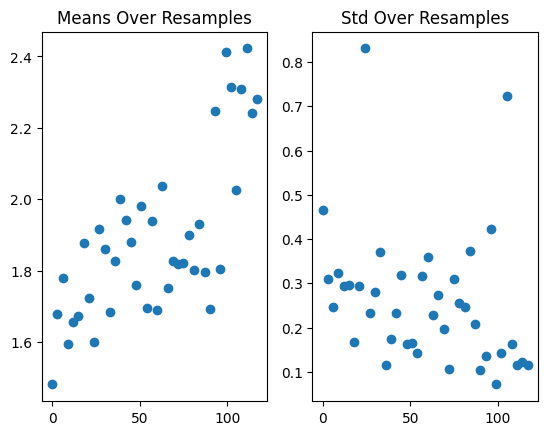

In [97]:
ind_scatters(1, ppo_data)

(array([9.830e+02, 1.199e+03, 5.090e+02, 2.930e+02, 2.220e+02, 9.600e+01,
        4.900e+01, 2.400e+01, 3.000e+00, 1.000e+00]),
 array([0.        , 0.1822044 , 0.36440879, 0.54661319, 0.72881759,
        0.91102198, 1.09322638, 1.27543078, 1.45763517, 1.63983957,
        1.82204397]),
 <BarContainer object of 10 artists>)

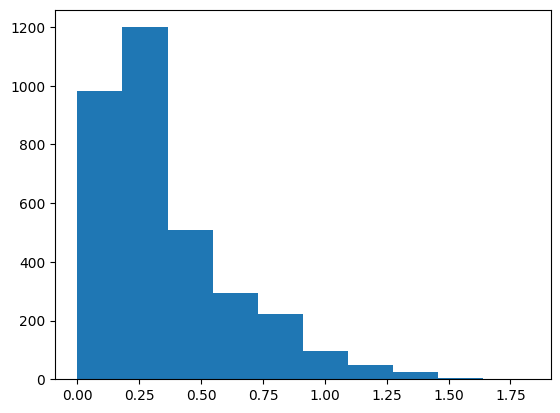

In [62]:
plt.hist([stdev(s) for s in ppo_data.scos])

(array([  7.,  20.,  52.,  98., 243., 630., 957., 965., 369.,  38.]),
 array([-0.3565889 , -0.05911712,  0.23835466,  0.53582644,  0.83329822,
         1.13077   ,  1.42824178,  1.72571356,  2.02318534,  2.32065712,
         2.6181289 ]),
 <BarContainer object of 10 artists>)

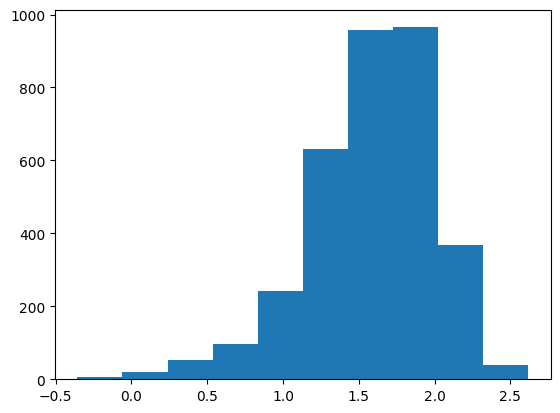

In [7]:
plt.hist([mean(s) for s in ppo_data.scos])

In [5]:
ppo_data

,inp,hyps,scos,prefix
0,Below is an instruction that describes a task....,[Below is an instruction that describes a task...,"[1.4455330372000001, 1.3290436267999999, 1.329...",0.0
1,Below is an instruction that describes a task....,[Below is an instruction that describes a task...,"[-0.5736763477, 1.594229579, -0.1385508627, 1....",69.0
2,Below is an instruction that describes a task....,[Below is an instruction that describes a task...,"[1.6271995306, 1.572941184, 1.3370450735000001...",72.0
3,Below is an instruction that describes a task....,[Below is an instruction that describes a task...,"[1.2783640623, 1.3673614264, 0.894701719300000...",75.0
4,Below is an instruction that describes a task....,[Below is an instruction that describes a task...,"[1.2990484238, 1.7066233158, 1.552518367799999...",78.0
...,...,...,...,...
3374,Below is an instruction that describes a task....,[Below is an instruction that describes a task...,"[1.8994317055, 1.7169818878, 2.4637775421, 1.4...",127.0
3375,Below is an instruction that describes a task....,[Below is an instruction that describes a task...,"[1.6888713837, 2.0935816765, 1.5731861591, 2.0...",130.0
3376,Below is an instruction that describes a task....,[Below is an instruction that describes a task...,"[2.2624211311, 1.8927211761, 2.1232714653, 1.5...",133.0
3377,Below is an instruction that describes a task....,[Below is an instruction that describes a task...,"[2.3049564362, 2.0557906628, 1.3633817434, 2.3...",136.0
